# 1 - Data Importation & Processing

Worked on by Vionna Atefi

In this part of the assignment I will work on importing the testing data, 
extracting the correct features, and turning our data into a vector that can later be used 
by a machine learning classifier. 

In [1]:
def add_to_corpus(corpus, list_of_author_files):
        
    corpus = set() # make corpus a set to avoid duplicates

    for author_filename in list_of_author_files:
        with open (author_filename, 'r') as file:
            all_txt = file.read()
            all_txt = all_txt.lower()
            # remove quotation marks and punctuation
            all_txt = all_txt.replace('"', '')
            all_txt = all_txt.replace('?', '')
            all_txt = all_txt.replace('!', '')
            all_txt = all_txt.replace('.', '')
            all_txt = all_txt.replace(',', '')
            all_txt = all_txt.replace(';', '')
            all_txt = all_txt.replace('(', '')
            all_txt = all_txt.replace(')', '')
            all_txt = all_txt.replace('-', '')
            list_of_words = all_txt.split() # separates based on spaces
            
            for word in list_of_words: 
                corpus.add(word)          
    
    return sorted(corpus) # returns a list

In [2]:
NUM_CISWOMEN = 8
NUM_CISMEN = 8
NUM_TRANSWOMEN = 0
NUM_TRANSMEN = 0
NUM_NONBINARY = 0

NUM_TRAINING_EXAMPLES = NUM_CISWOMEN + NUM_CISMEN + NUM_TRANSWOMEN + NUM_TRANSMEN + NUM_NONBINARY

# 2 - Train Classifier

Train a neural net with X and Y 

For first milestone, treat it as a binary classification problem. A cisWoman is the positive class, and every other gender identity is the negative class

In [55]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

def return_embeddings():
    
    # get embeddings

    array_of_text = []

    list_of_author_files = ["AnneBronte.txt", "Alcott.txt", "Austen.txt", "CharlotteBronte.txt", "Eliot.txt", "EmilyBronte.txt", "Gaskell.txt", "Shelley.txt", "Conrad.txt", "Dickens.txt", "Dostoevsky.txt", "Flaubert.txt", "Hardy.txt", "Melville.txt", "Stoker.txt", "Wilde.txt"]

    for author_filename in list_of_author_files:
        with open (author_filename, 'r') as file:
            all_txt = file.read()
            array_of_text.append(all_txt)

    count_vect = CountVectorizer()
    count_matrix = count_vect.fit_transform(array_of_text)
    array_of_feature_names = count_vect.get_feature_names_out()
    count_matrix = count_matrix.toarray()

# create a gender identity specific dictionaries 
# key = eg. Austen.txt (str)
# vale = [0 0 0 ... 2 3 0] (list of integers)
# should looop over the entirety of the list_of_author_files

    # **NOTE: These are very sparse vectors

    # create X matrix and Y vector for ML
        
    n = NUM_TRAINING_EXAMPLES
    Y_cisWomen = np.zeros((n, 1))
    Y_cisMen = np.zeros((n, 1))
        
    for j in range(NUM_CISWOMEN): # cisWomen as the positive class 
        Y_cisWomen[j] = 1;
        
    for j in range(NUM_CISWOMEN, NUM_CISWOMEN + NUM_CISMEN):
        Y_cisMen[j] = 1;
    
    return count_matrix, Y_cisWomen, array_of_feature_names

In [56]:
(X, Y, array_of_feature_names) = return_embeddings()
print(X)
print(Y)
print(array_of_feature_names)

[[0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
['1500' '1827' '1st' ... 'youth' 'zembla' 'zone']


In [57]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

def f(z):
    return 1 / (1 + np.exp(-z))

def dfdz(z):
    return f(z) * (1 - f(z))

def J(y, yhat):
    eps = 1e-8
    return -(yhat * np.log(y+eps) + (1-yhat) * np.log(1-y+eps))

def dJdy(y, yhat):
    eps = 1e-8
    return (1-yhat)/(1-y+eps) - yhat/(y+eps)

def forward(x, w):
    return f(np.dot(x, w))

## Option one: use the given derivatives (clearer)
def backward1(x, w, y, yhat):
    z = np.dot(x, w)
    dzdw = x
    return dJdy(y, yhat) * dfdz(z) * dzdw

## Option two: use the explicit calculted form (faster)
def backward2(x, y, yhat):  # w not needed for this form
    return ( y*(1-yhat) - yhat*(1-y) ) * x

def update(w, alpha, step):
    return w - alpha * step

def train(X, yhat, n_epoch, alpha):
    X_withbias = np.hstack([np.ones((X.shape[0],1)), X])  # fix x_0 = 1
    
    # keep track of performance during training
    costs = np.zeros(shape=(n_epoch,))

    # random nonzero initialization
    w = np.random.normal(0, 0.01, size=(X.shape[1]+1,))  # +1 for the bias

    for epoch in range(n_epoch):
        for i, x in enumerate(X_withbias):
            y = forward(x, w)  # prediction for one sample
            step = backward2(x, y, yhat[i])  # step to take, yhat[i] to just get this sample
            w = update(w, alpha, step)  # update weights
        
        # ### Some niceness to see our progress
        # Calculate total cost after epoch
        predictions = forward(X_withbias, w)  # predictions for entire set
        costs[epoch] = np.mean(J(predictions, yhat))  # mean cost per sample
        # report progress
        
        # accuracy = np.mean(predictions.round() == yhat)  # current accuracy on entire set
        # print('Training accuracy after epoch {}: {:.4%}'.format(epoch, accuracy))
        
        if ((epoch % 10) == 0) or (epoch == (n_epoch - 1)):
            accuracy = np.mean(predictions.round() == yhat)  # current accuracy on entire set
            print('Training accuracy after epoch {}: {:.4%}'.format(epoch, accuracy))
            # find some way to print each of the predictions (Type 1, Type 2 error)
            # can we visualize the data somehow?
            
    return w, costs


Training accuracy after epoch 0: 50.0000%
Training accuracy after epoch 10: 100.0000%
Training accuracy after epoch 20: 100.0000%
Training accuracy after epoch 30: 100.0000%
Training accuracy after epoch 40: 100.0000%
Training accuracy after epoch 50: 100.0000%
Training accuracy after epoch 60: 100.0000%
Training accuracy after epoch 70: 100.0000%
Training accuracy after epoch 80: 100.0000%
Training accuracy after epoch 90: 100.0000%
Training accuracy after epoch 100: 100.0000%
Training accuracy after epoch 110: 100.0000%
Training accuracy after epoch 120: 100.0000%
Training accuracy after epoch 130: 100.0000%
Training accuracy after epoch 140: 100.0000%
Training accuracy after epoch 150: 100.0000%
Training accuracy after epoch 160: 100.0000%
Training accuracy after epoch 170: 100.0000%
Training accuracy after epoch 180: 100.0000%
Training accuracy after epoch 190: 100.0000%
Training accuracy after epoch 199: 100.0000%


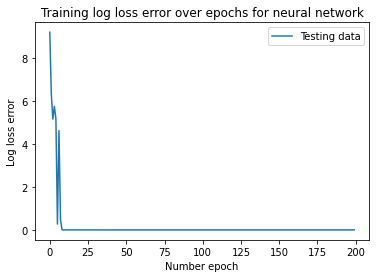

Three largest weights are 1.3961916952159055 0.697138519144144 0.5844332185127686
Associated feature names are: myriads young shed
Weight associated with the word 'her': 0.03474990099493463
Weight associated with the word 'she': -0.014638471018266515
Weight associated with the word 'his': 0.03803155307149562
Weight associated with the word 'he': -0.052606556590238086
Weight associated with the word 'him': -0.0056214836748291665
Weight associated with the word 'I': 0
Weight associated with the word 'kindness': -0.002195984831150665
Weight associated with the word 'home': 0.0029725541715163416
Weight associated with the word 'miss': 0.0194610670572394
Weight associated with the word 'mr': 0.017255650062715774
Weight associated with the word 'family': -0.001855743486225099
Weight associated with the word 'father': -0.02449108845070152
Weight associated with the word 'mother': -0.05762834017348779
Weight associated with the word 'sister': 0.059472462469435834
Weight associated with the wor

In [65]:

import matplotlib.pyplot as plt

(X, Y, array_of_feature_names) = return_embeddings()

n_epoch = 200
alpha = 0.01

Y = Y.ravel()

w, costs = train(X, Y, n_epoch, alpha)

# plot costs over number of epochs

epochs_list = []

for j in range(n_epoch):
    epochs_list.append(j)

x1 = epochs_list
y1 = costs

plt.plot(x1, y1, label = "Testing data")
plt.xlabel("Number epoch")
plt.ylabel("Log loss error")
plt.title("Training log loss error over epochs for neural network")
plt.legend()
plt.show()

# iterate through the w list and find the 10 biggest weights and their corresponding feature names

w = w.tolist()
array_of_feature_names = array_of_feature_names.tolist()

w1 = 0
feature_name1 = ""
w2 = 0
feature_name2 = ""
w3 = 0
feature_name3 = ""

her_weight = 0
she_weight = 0
his_weight = 0
he_weight = 0
him_weight = 0
I_weight = 0
kindness_weight = 0
home_weight = 0
miss_weight = 0
mr_weight = 0
family_weight = 0
father_weight = 0
mother_weight = 0
sister_weight = 0
brother_weight = 0

for j in range(len(w) - 1):
    curr_w = w[j]
    curr_feature_name = array_of_feature_names[j]
    if (abs(curr_w) > w1 or abs(curr_w) > w2 or abs(curr_w) > w3):
        if (abs(curr_w) > w1):
            w1 = curr_w
            feature_name1 = curr_feature_name
            continue
        if (abs(curr_w) > w2):
            w2 = curr_w
            feature_name2 = curr_feature_name
            continue
        if (abs(curr_w) > w3):
            w3 = curr_w
            feature_name3 = curr_feature_name
    if (curr_feature_name == "her"):
        her_weight = curr_w
    if (curr_feature_name == "she"):
        she_weight = curr_w
    if (curr_feature_name == "his"):
        his_weight = curr_w
    if (curr_feature_name == "he"):
        he_weight = curr_w
    if (curr_feature_name == "him"):
        him_weight = curr_w
    if (curr_feature_name == "i"):
        I_weight = curr_w
    if (curr_feature_name == "kindness"):
        kindness_weight = curr_w
    if (curr_feature_name == "home"):
        home_weight = curr_w
    if (curr_feature_name == "miss"):
        miss_weight = curr_w
    if (curr_feature_name == "mr"):
        mr_weight = curr_w
    if (curr_feature_name == "family"):
        family_weight = curr_w
    if (curr_feature_name == "father"):
        father_weight = curr_w
    if (curr_feature_name == "mother"):
        mother_weight = curr_w
    if (curr_feature_name == "sister"):
        sister_weight = curr_w
    if (curr_feature_name == "brother"):
        brother_weight = curr_w

print("Three largest weights are", w1, w2, w3)
print("Associated feature names are:", feature_name1, feature_name2, feature_name3)
print("Weight associated with the word 'her':", her_weight)
print("Weight associated with the word 'she':", she_weight)
print("Weight associated with the word 'his':", his_weight)
print("Weight associated with the word 'he':", he_weight)
print("Weight associated with the word 'him':", him_weight)
print("Weight associated with the word 'I':", I_weight)
print("Weight associated with the word 'kindness':", kindness_weight)
print("Weight associated with the word 'home':", home_weight)
print("Weight associated with the word 'miss':", miss_weight)
print("Weight associated with the word 'mr':", mr_weight)
print("Weight associated with the word 'family':", family_weight)
print("Weight associated with the word 'father':", father_weight)
print("Weight associated with the word 'mother':", mother_weight)
print("Weight associated with the word 'sister':", sister_weight)
print("Weight associated with the word 'brother':", brother_weight)
            

# print(array_of_feature_names.tolist())
# print(w)

# can test using w * newX input matric, and rounding for the predictions

In [59]:
NUM_WOMEN_TEST = 5
NUM_MEN_TEST = 9
NUM_WOMEN_TRAIN = 8
NUM_MEN_TRAIN = 8

Training accuracy after epoch 0: 50.0000%
Training accuracy after epoch 10: 100.0000%
Training accuracy after epoch 20: 100.0000%
Training accuracy after epoch 30: 100.0000%
Training accuracy after epoch 40: 100.0000%
Training accuracy after epoch 50: 100.0000%
Training accuracy after epoch 60: 100.0000%
Training accuracy after epoch 70: 100.0000%
Training accuracy after epoch 80: 100.0000%
Training accuracy after epoch 90: 100.0000%
Training accuracy after epoch 100: 100.0000%
Training accuracy after epoch 110: 100.0000%
Training accuracy after epoch 120: 100.0000%
Training accuracy after epoch 130: 100.0000%
Training accuracy after epoch 140: 100.0000%
Training accuracy after epoch 150: 100.0000%
Training accuracy after epoch 160: 100.0000%
Training accuracy after epoch 170: 100.0000%
Training accuracy after epoch 180: 100.0000%
Training accuracy after epoch 190: 100.0000%
Training accuracy after epoch 200: 100.0000%
[0.99893223]
Predictions for TestingAusten.txt is: female
Mean squa

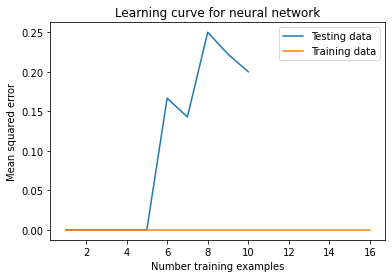

In [73]:
# INITIAL TESTING PROTOCOL

import matplotlib.pyplot as plt
    
array_of_text = []

list_of_author_files = ["AnneBronte.txt", "Alcott.txt", "Austen.txt", "CharlotteBronte.txt", "Eliot.txt", "EmilyBronte.txt", "Gaskell.txt", "Shelley.txt", "Conrad.txt", "Dickens.txt", "Dostoevsky.txt", "Flaubert.txt", "Hardy.txt", "Melville.txt", "Stoker.txt", "Wilde.txt"]

for author_filename in list_of_author_files:
    with open (author_filename, 'r') as file:
        all_txt = file.read()
        array_of_text.append(all_txt)
    
list_of_testing_author_files = ['TestingAusten.txt', 'TestingHarrietBeecherStowe.txt', 'TestingPerkinsGilman.txt', 'TestingAnneOfGreenGables.txt', 'TestingSecretGarden.txt', 'TestingDickens.txt', 'TestingJames.txt', 'TestingCarroll.txt', 'TestingHawthorne.txt', 'TestingJekhylHyde.txt']
    
array_of_testing_text = []
    
for testing_author_filename in list_of_testing_author_files:
    with open (testing_author_filename, 'r') as file:
        new_text = file.read()
        array_of_testing_text.append(new_text)
            

count_vect = CountVectorizer()
count_matrix = count_vect.fit_transform(array_of_text)

new_embedding = []

(X, Y, array_of_feature_names) = return_embeddings()

n_epoch = 201
alpha = 0.01

Y = Y.ravel()

w, costs = train(X, Y, n_epoch, alpha) # train model

true_positives = 0
false_positives = 0
true_negatives = 0
false_negatives = 0

predictions_women = 0
predictions_men = 0

mean_squared_error = 0
mean_squared_errors = []
m_values = []

for j in range(len(array_of_testing_text)):
    new_document = array_of_testing_text[j]
    new_embedding = count_vect.transform([new_document]).toarray()
    
# protocol to make prediction

    X_withbias = np.hstack([np.ones((new_embedding.shape[0],1)), new_embedding])  # fix x_0 = 1

    predictions = forward(X_withbias, w)
    
    if (predictions.round() == 1):
        print(predictions)
        print("Predictions for", list_of_testing_author_files[j], "is: female")
        if (j < NUM_WOMEN_TEST): # we're actually looking at a woman
            true_positives += 1
            print("Mean squared error is", (mean_squared_error / (j + 1)))
            mean_squared_errors.append((mean_squared_error / (j + 1)))
            m_values.append((j+1))
        else:
            false_positives += 1
            mean_squared_error += 1
            print("Mean squared error is", (mean_squared_error / (j + 1)))
            mean_squared_errors.append((mean_squared_error / (j + 1)))
            m_values.append((j+1))
    
    else:
        print(predictions)
        print("Predictions for", list_of_testing_author_files[j], "is: male")
        if (j < NUM_WOMEN_TEST):
            false_negatives += 1
            mean_squared_error += 1
            print("Mean squared error is", (mean_squared_error / (j + 1)))
            mean_squared_errors.append((mean_squared_error / (j + 1)))
            m_values.append((j+1))
        else:
            true_negatives += 1
            print("Mean squared error is", (mean_squared_error / (j + 1)))
            mean_squared_errors.append((mean_squared_error / (j + 1)))
            m_values.append((j+1))
        
# error metrics

accuracy = (true_positives + true_negatives) / (true_positives + false_positives + true_negatives + false_negatives)
recall = (true_positives) / (true_positives + false_negatives)
precision = (true_positives) / (true_positives + false_positives)
        
print("Accuracy for testing data is", accuracy)
print("Recall is", recall)
print("Precision is", precision)

################################################################################

# repeat error protocol for testing data

true_positives_train = 0
false_positives_train = 0
true_negatives_train = 0
false_negatives_train = 0

mean_squared_error_train = 0
mean_squared_errors_train = []
m_values_train = []

for j in range(len(array_of_text)):
    new_document = array_of_text[j]
    new_embedding = count_vect.transform([new_document]).toarray()
    
# protocol to make prediction

    X_withbias = np.hstack([np.ones((new_embedding.shape[0],1)), new_embedding])  # fix x_0 = 1

    predictions = forward(X_withbias, w)
    
    if (predictions.round() == 1):
        if (j < NUM_WOMEN_TRAIN): # we're actually looking at a woman
            true_positives += 1
            mean_squared_errors_train.append((mean_squared_error_train / (j + 1)))
            m_values_train.append((j+1))
        else:
            false_positives += 1
            mean_squared_error += 1
            mean_squared_errors_train.append((mean_squared_error_train / (j + 1)))
            m_values_train.append((j+1))
    
    else:
        if (j < NUM_WOMEN_TRAIN):
            false_negatives += 1
            mean_squared_error += 1
            mean_squared_errors_train.append((mean_squared_error_train / (j + 1)))
            m_values_train.append((j+1))
        else:
            true_negatives += 1
            mean_squared_errors_train.append((mean_squared_error_train / (j + 1)))
            m_values_train.append((j+1))

# plotting protocol

x1 = m_values
y1 = mean_squared_errors
x2 = m_values_train
y2 = mean_squared_errors_train

plt.plot(x1, y1, label = "Testing data")
plt.plot(x2, y2, label = "Training data")
plt.xlabel("Number training examples")
plt.ylabel("Mean squared error")
plt.title("Learning curve for neural network")
plt.legend()
plt.show()




# Possible Ways to Handle Situations of Overfitting

A) Get more training examples

B) Try using a smaller set of features

C) Try regularizing the cost function

D) Try using a smaller number of epochs


Training accuracy after epoch 0: 50.0000%
Training accuracy after epoch 4: 75.0000%
[4.64182605e-10]
Predictions for TestingAusten.txt is: male
Mean squared error is 1.0
[1.29783847e-08]
Predictions for TestingHarrietBeecherStowe.txt is: male
Mean squared error is 1.0
[0.99999965]
Predictions for TestingPerkinsGilman.txt is: female
Mean squared error is 0.6666666666666666
[9.81526307e-12]
Predictions for TestingAnneOfGreenGables.txt is: male
Mean squared error is 0.75
[0.99999108]
Predictions for TestingSecretGarden.txt is: female
Mean squared error is 0.6
[1.36988667e-06]
Predictions for TestingDickens.txt is: male
Mean squared error is 0.5
[3.55489326e-40]
Predictions for TestingJames.txt is: male
Mean squared error is 0.42857142857142855
[4.3543108e-06]
Predictions for TestingCarroll.txt is: male
Mean squared error is 0.375
[1.04355818e-20]
Predictions for TestingHawthorne.txt is: male
Mean squared error is 0.3333333333333333
[1.49430132e-23]
Predictions for TestingJekhylHyde.txt is

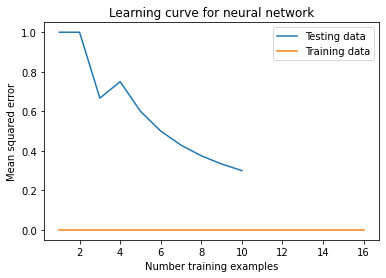

In [81]:
# INITIAL ATTEMPT TO MITIGATE OVERFITTING: EPOCHS

import matplotlib.pyplot as plt
    
array_of_text = []

list_of_author_files = ["AnneBronte.txt", "Alcott.txt", "Austen.txt", "CharlotteBronte.txt", "Eliot.txt", "EmilyBronte.txt", "Gaskell.txt", "Shelley.txt", "Conrad.txt", "Dickens.txt", "Dostoevsky.txt", "Flaubert.txt", "Hardy.txt", "Melville.txt", "Stoker.txt", "Wilde.txt"]

for author_filename in list_of_author_files:
    with open (author_filename, 'r') as file:
        all_txt = file.read()
        array_of_text.append(all_txt)
    
list_of_testing_author_files = ['TestingAusten.txt', 'TestingHarrietBeecherStowe.txt', 'TestingPerkinsGilman.txt', 'TestingAnneOfGreenGables.txt', 'TestingSecretGarden.txt', 'TestingDickens.txt', 'TestingJames.txt', 'TestingCarroll.txt', 'TestingHawthorne.txt', 'TestingJekhylHyde.txt']
# list_of_testing_author_files = ['TestingAusten.txt', 'TestingHarrietBeecherStowe.txt', 'TestingPerkinsGilman.txt', 'TestingAnneOfGreenGables.txt', 'TestingSecretGarden.txt', 'TestingDickens.txt', 'TestingJames.txt', 'TestingCarroll.txt', 'TestingTwain.txt', 'TestingTolstoy.txt', 'TestingDavidCopperfield.txt', 'TestingHawthorne.txt', 'TestingTellTaleHeart.txt', 'TestingJekhylHyde.txt']
    
array_of_testing_text = []
    
for testing_author_filename in list_of_testing_author_files:
    with open (testing_author_filename, 'r') as file:
        new_text = file.read()
        array_of_testing_text.append(new_text)
            

count_vect = CountVectorizer()
count_matrix = count_vect.fit_transform(array_of_text)

new_embedding = []

(X, Y, array_of_feature_names) = return_embeddings()

n_epoch = 5
alpha = 0.01

Y = Y.ravel()

w, costs = train(X, Y, n_epoch, alpha) # train model

true_positives = 0
false_positives = 0
true_negatives = 0
false_negatives = 0

predictions_women = 0
predictions_men = 0

mean_squared_error = 0
mean_squared_errors = []
m_values = []

for j in range(len(array_of_testing_text)):
    new_document = array_of_testing_text[j]
    new_embedding = count_vect.transform([new_document]).toarray()
    
# protocol to make prediction

    X_withbias = np.hstack([np.ones((new_embedding.shape[0],1)), new_embedding])  # fix x_0 = 1

    predictions = forward(X_withbias, w)
    
    if (predictions.round() == 1):
        print(predictions)
        print("Predictions for", list_of_testing_author_files[j], "is: female")
        if (j < NUM_WOMEN_TEST): # we're actually looking at a woman
            true_positives += 1
            print("Mean squared error is", (mean_squared_error / (j + 1)))
            mean_squared_errors.append((mean_squared_error / (j + 1)))
            m_values.append((j+1))
        else:
            false_positives += 1
            mean_squared_error += 1
            print("Mean squared error is", (mean_squared_error / (j + 1)))
            mean_squared_errors.append((mean_squared_error / (j + 1)))
            m_values.append((j+1))
    
    else:
        print(predictions)
        print("Predictions for", list_of_testing_author_files[j], "is: male")
        if (j < NUM_WOMEN_TEST):
            false_negatives += 1
            mean_squared_error += 1
            print("Mean squared error is", (mean_squared_error / (j + 1)))
            mean_squared_errors.append((mean_squared_error / (j + 1)))
            m_values.append((j+1))
        else:
            true_negatives += 1
            print("Mean squared error is", (mean_squared_error / (j + 1)))
            mean_squared_errors.append((mean_squared_error / (j + 1)))
            m_values.append((j+1))
        
# error metrics

accuracy = (true_positives + true_negatives) / (true_positives + false_positives + true_negatives + false_negatives)
recall = (true_positives) / (true_positives + false_negatives)
precision = (true_positives) / (true_positives + false_positives)
        
print("Accuracy for testing data is", accuracy)
print("Recall is", recall)
print("Precision is", precision)

################################################################################

# repeat error protocol for testing data

true_positives_train = 0
false_positives_train = 0
true_negatives_train = 0
false_negatives_train = 0

mean_squared_error_train = 0
mean_squared_errors_train = []
m_values_train = []

for j in range(len(array_of_text)):
    new_document = array_of_text[j]
    new_embedding = count_vect.transform([new_document]).toarray()
    
# protocol to make prediction

    X_withbias = np.hstack([np.ones((new_embedding.shape[0],1)), new_embedding])  # fix x_0 = 1

    predictions = forward(X_withbias, w)
    
    if (predictions.round() == 1):
        if (j < NUM_WOMEN_TRAIN): # we're actually looking at a woman
            true_positives += 1
            mean_squared_errors_train.append((mean_squared_error_train / (j + 1)))
            m_values_train.append((j+1))
        else:
            false_positives += 1
            mean_squared_error += 1
            mean_squared_errors_train.append((mean_squared_error_train / (j + 1)))
            m_values_train.append((j+1))
    
    else:
        if (j < NUM_WOMEN_TRAIN):
            false_negatives += 1
            mean_squared_error += 1
            mean_squared_errors_train.append((mean_squared_error_train / (j + 1)))
            m_values_train.append((j+1))
        else:
            true_negatives += 1
            mean_squared_errors_train.append((mean_squared_error_train / (j + 1)))
            m_values_train.append((j+1))

# plotting protocol

x1 = m_values
y1 = mean_squared_errors
x2 = m_values_train
y2 = mean_squared_errors_train

plt.plot(x1, y1, label = "Testing data")
plt.plot(x2, y2, label = "Training data")
plt.xlabel("Number training examples")
plt.ylabel("Mean squared error")
plt.title("Learning curve for neural network")
plt.legend()
plt.show()

In [ ]:
# Trying to regularize the cost function

